# Sentiment Analysis using Many-to-few RNN 

we will construct a many-to-one RNN how how they many be used for classification and prediction
ecurrent neural network is any network with nodes that update their state between *prediction* runs. This is in contrast to a perceptron or CNN which only updates it state during training. A RNN is composted of __memory cells__, which hold a state between prediction runs, the most popular of which are LSTM and GRU cells. RNN's are trained by "unfolding" them to the desired input size, with the weights of each cell shared across the unfolding:

<img width=800px src="https://raw.githubusercontent.com/tipthederiver/Math-7243-2020/master/Labs/Lab%206/Lab%206%20RNN%20Unroll.PNG">



 We will Construct a __many to few__ RNN for the classification of text sentiment. We will be classifying the IMDB user comments database to see to see if reviews are positive or negative. 

## Step 1 : Load the dataset

In [1]:
import pandas as pd    # to load dataset
import numpy as np     # for mathematic equation
from nltk.corpus import stopwords   # to get collection of stopwords
from sklearn.model_selection import train_test_split       # for splitting dataset
from tensorflow.keras.preprocessing.text import Tokenizer  # to encode text to int
from tensorflow.keras.preprocessing.sequence import pad_sequences   # to do padding or truncating
from tensorflow.keras.models import Sequential     # the model
from tensorflow.keras.layers import Embedding, LSTM, Dense # layers of the architecture
from tensorflow.keras.callbacks import ModelCheckpoint   # save model
from tensorflow.keras.models import load_model   # load saved model
import re

In [2]:
data = pd.read_csv('IMDB Dataset.csv')

print(data)

                                                  review sentiment
0      One of the other reviewers has mentioned that ...  positive
1      A wonderful little production. <br /><br />The...  positive
2      I thought this was a wonderful way to spend ti...  positive
3      Basically there's a family where a little boy ...  negative
4      Petter Mattei's "Love in the Time of Money" is...  positive
...                                                  ...       ...
49995  I thought this movie did a down right good job...  positive
49996  Bad plot, bad dialogue, bad acting, idiotic di...  negative
49997  I am a Catholic taught in parochial elementary...  negative
49998  I'm going to have to disagree with the previou...  negative
49999  No one expects the Star Trek movies to be high...  negative

[50000 rows x 2 columns]


## Step 2: Data Pre-processing

In [3]:
x_data = data['review']       # Reviews/Input
y_data = data['sentiment']    # Sentiment/Output

### Pre-processing the reviews:
As reviews are unclean in the original dataset, we will clean them by removing html tags, non-alphabet such as punctuation and numbers and stop words. After that we will also lower_case them. 


In [4]:
stopwords=set(stopwords.words('english'))

In [5]:
#stopwords

In [6]:
x_data = x_data.replace({'<.*?>': ''}, regex = True)    # remove html tag
x_data = x_data.replace({'[^A-Za-z]': ' '}, regex = True)     # remove non alphabet
x_data = x_data.apply(lambda review: [w for w in review.split() if w not in stopwords ])  # remove stop words
x_data = x_data.apply(lambda review: [w.lower() for w in review])   # lower case

### Encoding Sentiments
We will encode are sentiments such that 1 means positive and 0 means negative

In [7]:
y_data = y_data.replace('positive', 1)
y_data = y_data.replace('negative', 0)

In [9]:
print('Reviews')
print(x_data, '\n')
print('Sentiment')
print(y_data)

Reviews
0        [one, reviewers, mentioned, watching, oz, epis...
1        [a, wonderful, little, production, the, filmin...
2        [i, thought, wonderful, way, spend, time, hot,...
3        [basically, family, little, boy, jake, thinks,...
4        [petter, mattei, love, time, money, visually, ...
                               ...                        
49995    [i, thought, movie, right, good, job, it, crea...
49996    [bad, plot, bad, dialogue, bad, acting, idioti...
49997    [i, catholic, taught, parochial, elementary, s...
49998    [i, going, disagree, previous, comment, side, ...
49999    [no, one, expects, star, trek, movies, high, a...
Name: review, Length: 50000, dtype: object 

Sentiment
0        1
1        1
2        1
3        0
4        1
        ..
49995    1
49996    0
49997    0
49998    0
49999    0
Name: sentiment, Length: 50000, dtype: int64


## Step 3: Splitting the data into Train and Test

In [10]:
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size = 0.2)

print('Train Set')
print(x_train, '\n')
print(x_test, '\n')
print('Test Set')
print(y_train, '\n')
print(y_test)

Train Set
13736    [great, news, bbc, dvd, release, scheduled, st...
3411     [ok, hell, supposed, mean, halloween, let, cal...
5604     [like, margot, fear, fear, falls, victim, ambi...
1794     [i, add, reviewers, already, made, clear, this...
37185    [in, years, film, going, i, walked, film, drea...
                               ...                        
42283    [i, honest, i, finally, checked, movie, stars,...
26313    [wouldn, great, not, another, teen, movie, act...
47613    [the, movie, bad, many, comments, pointed, obv...
18433    [this, movie, similar, play, entitled, blithe,...
12987    [i, rented, movie, primarily, meg, ryan, i, di...
Name: review, Length: 40000, dtype: object 

5171     [bourne, identity, one, time, favorite, movies...
37590    [this, bad, movie, i, laughed, twice, storylin...
18431    [it, terrible, people, get, away, things, this...
43976    [as, huge, fan, cracker, series, i, waiting, y...
25566    [i, initially, bought, dvd, srk, aishwarya, ra...
 

In [11]:
#calculating max length of a review
max_length=[]
for review in x_train:
    max_length.append(len(review))
    
        


In [12]:
##max_length

In [13]:
max_length=int(np.ceil(np.mean(max_length)))

In [14]:
max_length

130

In [15]:
#Encode Review 
token = Tokenizer(lower=False)#lower=flase because we have already made every word lower case 
token.fit_on_texts(x_train)
x_train = token.texts_to_sequences(x_train)
x_test = token.texts_to_sequences(x_test)
x_train = pad_sequences(x_train, maxlen=max_length, padding='post', truncating='post')
x_test = pad_sequences(x_test, maxlen=max_length, padding='post', truncating='post')

total_words = len(token.word_index) + 1   # add 1 because of 0 padding

print('Encoded X Train\n', x_train, '\n')
print('Encoded X Test\n', x_test, '\n')
print('Maximum review length: ', max_length)

Encoded X Train
 [[   21  1430  2108 ...     0     0     0]
 [  486   477   351 ...   477  5419  2244]
 [    6 17072  1057 ...   348   294     5]
 ...
 [    2     3    19 ...     0     0     0]
 [    8     3   636 ...     0     0     0]
 [    1  1464     3 ...     0     0     0]] 

Encoded X Test
 [[4233 2196    5 ...    0    0    0]
 [   8   19    3 ...    0    0    0]
 [   7  281   20 ...    0    0    0]
 ...
 [   8  150  281 ...    0    0    0]
 [   8  625 3381 ...    0    0    0]
 [   8   45 2404 ...    0    0    0]] 

Maximum review length:  130


## Step 4: Building the RNN Architecture

In [16]:
# ARCHITECTURE
EMBED_DIM = 32
LSTM_OUT = 64

model = Sequential()
model.add(Embedding(total_words, EMBED_DIM, input_length = max_length))
model.add(LSTM(LSTM_OUT))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 130, 32)           2962880   
                                                                 
 lstm (LSTM)                 (None, 64)                24832     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 2,987,777
Trainable params: 2,987,777
Non-trainable params: 0
_________________________________________________________________
None


## Step 5: Training the model 

For training, it is simple. We only need to fit our x_train (input) and y_train (output/label) data. For this training, I use a mini-batch learning method with a batch_size of 128 and 10 epochs.

In [17]:
checkpoint = ModelCheckpoint(
    'LSTM.h5',
    monitor='accuracy',
    save_best_only=True,
    verbose=1
)


In [18]:
validation_split = 0.1
history=model.fit(x_train, y_train, batch_size = 128, epochs = 6, callbacks=[checkpoint],validation_split=validation_split)

Epoch 1/6
282/282 [==============================] - ETA: 0s - loss: 0.5918 - accuracy: 0.6704
Epoch 1: accuracy improved from -inf to 0.67039, saving model to LSTM.h5
282/282 [==============================] - 90s 297ms/step - loss: 0.5918 - accuracy: 0.6704 - val_loss: 0.3751 - val_accuracy: 0.8572
Epoch 2/6
282/282 [==============================] - ETA: 0s - loss: 0.2929 - accuracy: 0.8872
Epoch 2: accuracy improved from 0.67039 to 0.88717, saving model to LSTM.h5
282/282 [==============================] - 81s 289ms/step - loss: 0.2929 - accuracy: 0.8872 - val_loss: 0.3169 - val_accuracy: 0.8845
Epoch 3/6
282/282 [==============================] - ETA: 0s - loss: 0.1615 - accuracy: 0.9486
Epoch 3: accuracy improved from 0.88717 to 0.94864, saving model to LSTM.h5
282/282 [==============================] - 82s 291ms/step - loss: 0.1615 - accuracy: 0.9486 - val_loss: 0.2861 - val_accuracy: 0.8823
Epoch 4/6
282/282 [==============================] - ETA: 0s - loss: 0.0965 - accuracy: 

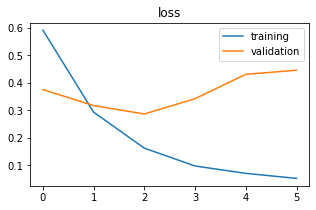

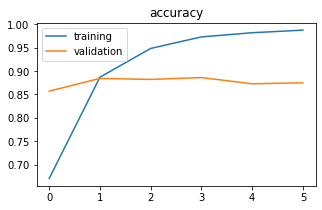

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5,3))
plt.plot(history.epoch,history.history['loss'], label='training')
plt.plot(history.epoch,history.history['val_loss'], label='validation')
plt.title('loss')
plt.legend(loc='best')

plt.figure(figsize=(5,3))
plt.plot(history.epoch,history.history['accuracy'], label='training')
plt.plot(history.epoch,history.history['val_accuracy'], label='validation')
plt.title('accuracy')
plt.legend(loc='best');


## Step 6: Testing
To evaluate the model, we need to predict the sentiment using our x_test data and comparing the predictions with y_test (expected output) data. Then, we calculate the accuracy of the model by dividing numbers of correct prediction with the total data. Resulted an accuracy of 86.63%

In [20]:
y_pred = model.predict(x_test)
y_pred = np.round(y_pred).astype(int)

true = 0
for i, y in enumerate(y_test):
    if y == y_pred[i]:
        true += 1

print('Correct Prediction: {}'.format(true))
print('Wrong Prediction: {}'.format(len(y_pred) - true))
print('Accuracy: {}'.format(true/len(y_pred)*100))

Correct Prediction: 8703
Wrong Prediction: 1297
Accuracy: 87.03


In [21]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

In [22]:
print('Precision: %.3f' % precision_score(y_test, y_pred))

Precision: 0.894


In [23]:
print('Recall: %.3f' % recall_score(y_test, y_pred))

Recall: 0.844


Text(0.5, 1.0, 'Confusion Matrix')

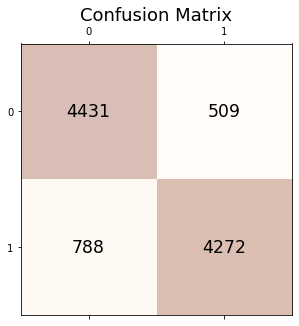

In [25]:
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y_true=y_test, y_pred=y_pred)
#
# Print the confusion matrix using Matplotlib
#
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 

plt.title('Confusion Matrix', fontsize=18)


## Step 7: Load the saved model

In [26]:
loaded_model = load_model('LSTM.h5')

In [34]:
review = str(input('Movie Review: '))

Movie Review: Worst movie ever, characters were one dimensional, the directors lacked vision 


In [35]:
#Let's preprocess the input before entering it into the model 
regex = re.compile(r'[^a-zA-Z\s]')
review = regex.sub('', review)
print('Cleaned: ', review)

words = review.split(' ')
filtered_text = [w for w in words if w not in stopwords]
filtered_text = ' '.join(filtered_text)
filtered_text = [filtered_text.lower()]

print('Filtered: ', filtered_text)

Cleaned:  Worst movie ever characters were one dimensional the directors lacked vision 
Filtered:  ['worst movie ever characters one dimensional directors lacked vision ']


In [36]:
texts = filtered_text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)
tokenize_words = tokenizer.texts_to_sequences(texts)

In [37]:
tokenize_words = pad_sequences(tokenize_words, maxlen=max_length, padding='post', truncating='post')

In [38]:

print(tokenize_words)

[[1 2 3 4 5 6 7 8 9 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]


In [39]:
result = loaded_model.predict(tokenize_words)
print(result)

[[0.08096951]]


In [40]:
if result >= 0.6: #0.6 is the threshold
    print('positive')
else:
    print('negative')

negative
